In [ ]:
import os
import scipy
import logging
import tempfile
import numpy as np
import nibabel as nib
import multiprocessing
from dipy.data import get_sphere
from dipy.io import read_bvals_bvecs
from joblib import Parallel, delayed
from scilpy.reconst.sh import compute_rish
from dipy.core.sphere import Sphere
from dipy.reconst.shm import sf_to_sh
from dipy.core.gradients import gradient_table_from_bvals_bvecs
from scilpy.reconst.multi_processes import fit_from_model, convert_sh_basis
from scilpy.reconst.raw_signal import compute_sh_coefficients
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.shm import real_sh_descoteaux_from_index, sh_to_sf
from scilpy.utils.bvec_bval_tools import (DEFAULT_B0_THRESHOLD,
                                          check_b0_threshold, identify_shells,
                                          is_normalized_bvecs, normalize_bvecs)
from scilpy.utils.bvec_bval_tools import fsl2mrtrix, identify_shells

In [ ]:
n = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
vol = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz')
og_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bvec'
ob_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
vec_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bvec'
val_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bval'
pk_corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()

In [ ]:
tmp_scheme_filename = os.path.join('gradients.scheme')
tmp_bval_filename = os.path.join('bval')
bvals, _ = read_bvals_bvecs(ob_file, og_file)
shells_centroids, indices_shells = identify_shells(bvals,
                                                    roundCentroids=True)
np.savetxt(tmp_bval_filename, shells_centroids[indices_shells],
            newline=' ', fmt='%i')
fsl2mrtrix(tmp_bval_filename, og_file, tmp_scheme_filename)

In [ ]:
def compute_dwi_attenuation(dwi_weights: np.ndarray, b0: np.ndarray):
    """ Compute signal attenuation by dividing the dwi signal with the b0.
    Parameters:
    -----------
    dwi_weights : np.ndarray of shape (X, Y, Z, #gradients)
        Diffusion weighted images.
    b0 : np.ndarray of shape (X, Y, Z)
        B0 image.
    Returns
    -------
    dwi_attenuation : np.ndarray
        Signal attenuation (Diffusion weights normalized by the B0).
    """
    b0 = b0[..., None]  # Easier to work if it is a 4D array.

    # Make sure that, in every voxels, weights are lower in the b0. Should
    # always be the case, but with the noise we never know!
    erroneous_voxels = np.any(dwi_weights > b0, axis=3)
    nb_erroneous_voxels = np.sum(erroneous_voxels)
    if nb_erroneous_voxels != 0:
        logging.info("# of voxels where `dwi_signal > b0` in any direction: "
                     "{}".format(nb_erroneous_voxels))
        dwi_weights = np.minimum(dwi_weights, b0)

    # Compute attenuation
    dwi_attenuation = dwi_weights / b0

    # Make sure we didn't divide by 0.
    dwi_attenuation[np.logical_not(np.isfinite(dwi_attenuation))] = 0.

    return dwi_attenuation

In [ ]:
def val_emp(i,j,k,n,og_bval,bvec_stack,bval_stack,emp_sh,sh_order):
        dwi = n[i][j][k]
        vec = bvec_stack[i,j,k,:,:]
        val = bval_stack[i,j,k,:]
        gradient_table = gradient_table_from_bvals_bvecs(val, vec)
        sh_order=sh_order
        basis_type='tournier07'
        smooth=0.00
        use_attenuation=True
        force_b0_threshold=False
        mask=None
        sphere=None

        # Extracting infos
        b0_mask = gradient_table.b0s_mask
        bvecs = gradient_table.bvecs
        bvals = gradient_table.bvals
        
        dwi = np.reshape(dwi,[1,1,1,bvals.shape[0]])

        if not is_normalized_bvecs(bvecs):
                logging.warning("Your b-vectors do not seem normalized...")
                bvecs = normalize_bvecs(bvecs)

        b0_threshold = check_b0_threshold(force_b0_threshold, bvals.min())

        # Ensure that this is on a single shell.
        shell_values, _ = identify_shells(bvals)
        shell_values.sort()
        # if shell_values.shape[0] != 2 or shell_values[0] > b0_threshold:
        #     raise ValueError("Can only work on single shell signals.")

        # Keeping b0-based infos
        bvecs = bvecs[np.logical_not(b0_mask)]
        weights = dwi[..., np.logical_not(b0_mask)]

        b0 = dwi[..., b0_mask].mean(axis=3)
        norm_gg = np.divide(bvals[np.logical_not(b0_mask)] , og_bval[np.logical_not(b0_mask)])
        weights_scaled = b0 * np.exp (np.divide( (np.log (np.divide(weights,b0)) ) , norm_gg))

        # Compute attenuation using the b0.
        if use_attenuation:
                weights_scaled = compute_dwi_attenuation(weights_scaled, b0)

        # # Get cartesian coords from bvecs # from here cut debugging
        sphere = Sphere(xyz=bvecs)

        # SF TO SH
        # Fit SH
        sh = sf_to_sh(weights_scaled, sphere, sh_order, basis_type, smooth=smooth)
        emp_sh[i,j,k,:] = sh


In [ ]:
def val_pk(dwi1,og_bval,og_bvec,sh_order):
    og_gradient_table = gradient_table_from_bvals_bvecs(og_bval, og_bvec)
    pk_sh = compute_sh_coefficients(dwi1,og_gradient_table,sh_order=sh_order,basis_type='tournier07',use_attenuation=True,smooth=0.00)
    return pk_sh

In [ ]:
og_bval, og_bvec = read_bvals_bvecs(ob_file,og_file)
ind_1000 = np.where(og_bval == 1000)
ind_2000 = np.where(og_bval == 2000)
ind_b0 = np.nonzero(og_bval==0)
ind_b0 = np.squeeze(ind_b0)
ind_0_1000 = np.where((og_bval == 0) | (og_bval == 1000))
ind_0_2000 = np.where((og_bval == 0) | (og_bval == 2000))

# for 1000
len1 = ind_0_1000[0]
sh_order = 6
pk_sh1000 = val_pk(pk_corr_dwi1[:,:,:,len1],og_bval[len1],og_bvec[len1],sh_order)
# for 2000
len2 = ind_0_2000[0]
sh_order = 8
pk_sh2000 = val_pk(pk_corr_dwi1[:,:,:,len2],og_bval[len2],og_bvec[len2,:],sh_order)

In [ ]:
bvec_vols = []
for i in sorted(os.listdir(vec_folder)):
    if i.endswith('.nii.gz'):
        bvec_vol = nib.load(vec_folder + '/' + i).get_fdata()
        bvec_vol = np.expand_dims(bvec_vol,4)
        bvec_vol = np.transpose(bvec_vol,(0,1,2,4,3))
        bvec_vols.append(bvec_vol)
bvec_stack = np.stack(bvec_vols,3)
bvec_stack = bvec_stack.squeeze()

bval_vols = []
for i in sorted(os.listdir(val_folder)):
    if i.endswith('.nii.gz'):
        bval_vol = nib.load(val_folder + '/' + i).get_fdata()
        bval_vols.append(bval_vol)
bval_stack = np.stack(bval_vols,3)

In [ ]:
num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

# for dwi with 0 1000
len1 = ind_0_1000[0]
dwi_hat_path1 = os.path.join(path,'emp_sh1000.mmap')
emp_sh1000 = np.memmap(dwi_hat_path1, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],28), mode='w+')
data = n[:,:,:,len1]
org_bval = og_bval[len1]
corr_bvec = bvec_stack[:,:,:,len1,:]
corr_bval = bval_stack[:,:,:,len1]
sh_order=6
results = Parallel(n_jobs=num_cores)(delayed(val_emp)(i,j,k,data,org_bval,corr_bvec,corr_bval,emp_sh1000,sh_order) for k in zaxis for j in yaxis for i in xaxis)

In [ ]:

num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

len2 = ind_0_2000[0]
dwi_hat_path2 = os.path.join(path,'emp_sh2000.mmap')
emp_sh2000 = np.memmap(dwi_hat_path2, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],45), mode='w+')
data = n[:,:,:,len2]
org_bval = og_bval[len2]
corr_bvec = bvec_stack[:,:,:,len2,:]
corr_bval = bval_stack[:,:,:,len2]
sh_order=8

results = Parallel(n_jobs=num_cores)(delayed(val_emp)(i,j,k,data,org_bval,corr_bvec,corr_bval,emp_sh2000,sh_order) for k in zaxis for j in yaxis for i in xaxis)

In [ ]:
emp.shape

In [ ]:
pk_sh1000.shape 

In [ ]:
pk_sh2000.shape

In [ ]:
emp_sh2000[45][45][30][45]

In [ ]:
pk_sh2000[45][45][30][45]

In [ ]:
import numpy as np
import torch

def angularCorrCoeff(p_v, q_v):

    p = p_v.shape[-1]
    q = q_v.shape[-1]
    nCoeffs = min([p, q])

    p_v = p_v[..., 0:nCoeffs]
    q_v = q_v[..., 0:nCoeffs]

    zmp_v = p_v[..., 1:nCoeffs]
    zmq_v = q_v[..., 1:nCoeffs]

    np_v = np.rollaxis(zmp_v, -1)/ (np.sqrt(np.sum(zmp_v * np.conj(zmp_v), axis=-1)))
    nq_v = np.rollaxis(zmq_v, -1)/ (np.sqrt(np.sum(zmq_v * np.conj(zmq_v), axis=-1)))
    
    np_v = np.rollaxis(np_v,0,len(np_v.shape))
    nq_v = np.rollaxis(nq_v,0,len(nq_v.shape))

    acc = np.sum(np_v * np.conj(nq_v), axis=-1)

    return acc

In [ ]:
acc1 = angularCorrCoeff(emp_sh1000,pk_sh1000)

In [ ]:
np.nanmean(np.nanmean(acc1))

In [ ]:
acc1 = acc1[mask == 1]

In [ ]:
acc1 = angularCorrCoeff(emp,pk)

In [ ]:
np.nanmean(np.nanmean(acc1))

In [ ]:
from scilpy.reconst.sh import compute_rish

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [ ]:
pk_rish1000, final_orders = compute_rish(pk_sh1000,mask=mask)
emp_rish1000, final_orders = compute_rish(emp_sh1000,mask=mask)

In [ ]:
emp_rish2000, final_orders = compute_rish(emp_sh2000,mask=mask)
pk_rish2000, final_orders = compute_rish(pk_sh2000,mask=mask)

In [ ]:
emp_rish2000.shape

In [ ]:
acc2 = angularCorrCoeff(emp_rish1000[:,:,:,3],pk_rish1000[:,:,:,3])

In [ ]:
np.nanmean(np.nanmean(acc2))

In [ ]:
ind_0_1000 = np.where((og_bval == 0) | (og_bval == 1000))

In [ ]:
ind_0_1000

In [ ]:
pk_sh1000 = val_pk(pk_corr_dwi1[:,:,:,len1],og_bval[len1],og_bvec[len1,:])

In [ ]:
len1

In [ ]:
acc1000 = [0.8282973981832714, 0.8228604762732795,0.7930699216711522, 0.7983260829709444,0.804515810053933]

In [ ]:
acc2000 = [0.8326090974203082,0.8164530412158586,0.7901226112354409,0.8070315817082493,0.8000860330690326]

In [ ]:
acc1000 = [0.9770712734354825,0.9795263449200603,0.9757020790440663,0.9828990069525622,0.9643193990910122]
acc2000 = [0.972894914151945,0.9737851234494219,0.9740020420001775,0.9789930151456134,0.9615602517669753]

In [ ]:
acc1000 = [0.9999998440744354,0.9999981801423755,0.9999999934912266,0.9999998190844,0.9999999874208663]
acc2000 = [0.9999999736513395,0.9999993648525107,0.9999999885010696,0.9999999494809747,0.9999999971191664]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(8,5)) 
plt.scatter(range(5),acc1000,40,label='b1000')
plt.scatter(range(5),acc2000,40,label='b2000')
plt.legend()
plt.ylim((0.98,1.02))
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel('Subjects')
plt.ylabel('Mean ACC')
# plt.ylabel('ACC between SH of signal reconst. \n and SH of emp. voxelwise')

In [ ]:
acc1000 = [0.9904828919394973,0.987087871556337,0.9908236392712096,0.9875183958383225,0.9891097518815941]
acc2000 = [0.9792517992862245,0.9658582417455683,0.9883785019510217,0.9826812535794488,0.9804747002887525]

In [ ]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(8,5)) 
plt.scatter(range(5),acc1000,40,label='b1000')
plt.scatter(range(5),acc2000,40,label='b2000')
plt.legend(loc='lower right')
plt.ylim((0.96,1))
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel('Subjects')
plt.ylabel('Mean ACC')

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()


In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/brain_mask_dil.nii.gz').get_fdata()

In [ ]:
pk_rish1000, final_orders = compute_rish(pk_sh1000,mask=mask)
emp_rish1000, final_orders = compute_rish(emp_sh1000,mask=mask)



In [ ]:
emp_rish2000, final_orders = compute_rish(emp_sh2000,mask=mask)
pk_rish2000, final_orders = compute_rish(pk_sh2000,mask=mask)

In [ ]:
nib.save(nib.Nifti1Image(pk_rish1000.astype(np.float32),vol.affine),"pk_rish1000.nii" )
nib.save(nib.Nifti1Image(pk_rish2000.astype(np.float32),vol.affine),"pk_rish2000.nii" )
nib.save(nib.Nifti1Image(emp_rish1000.astype(np.float32),vol.affine),"emp_rish1000.nii" )
nib.save(nib.Nifti1Image(emp_rish2000.astype(np.float32),vol.affine),"emp_rish2000.nii" )

In [ ]:
import math
MSE = np.square(pk_rish2000[:,:,:,0] / pk_rish2000[:,:,:,0].max() ,emp_rish2000[:,:,:,0] / emp_rish2000[:,:,:,0].max()).mean() 
RMSE = math.sqrt(MSE)

In [ ]:
RMSE

In [ ]:
import math
MSE = np.square(np.subtract(pk_rish2000[:,:,:,0] ,emp_rish2000[:,:,:,0])).mean() 
RMSE = math.sqrt(MSE) 

In [ ]:
MSE = np.square(np.subtract(pk_rish1000[:,:,:,0] ,emp_rish1000[:,:,:,0])).mean()
RMSE = math.sqrt(MSE) #/ np.mean(emp_rish1000[:,:,:,0]) 

In [ ]:
RMSE

In [ ]:
MSE = np.square(np.std(pk_rish1000[:,:,:,0]) ,emp_rish1000[:,:,:,0]).mean()
RMSE = math.sqrt(MSE) / (np.mean(emp_rish1000[:,:,:,0]) )

In [ ]:
RMSE

In [ ]:
import nibabel as nib

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/brain_mask_dil.nii.gz').get_fdata()
# mask = mask.astype(int)
# from scipy import ndimage
# mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [ ]:
import numpy as np
import nibabel as nib 

In [ ]:
data = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/sub-cIVs001_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz')

img = data.get_fdata()

corr = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()

diff = data - corr

nib.save(nib.Nifti1Image(diff, data.affine), 'LR_diff.nii.gz')


In [ ]:
slice_idx = 60

slice = mask[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,2,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 1
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

In [ ]:
slice_idx = 60

slice = mask[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,2,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 1
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

In [ ]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(15,5))
slice_idx = 60
slice = pk_rish2000[:,:,:,0] - emp_rish2000[:,:,:,0]
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
# m = 0
# M = 1
plt.subplot(1,3,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice), cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = mask[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,3,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 1
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = pk_rish2000[:,:,:,2] 
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(1,3,3)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice), cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)


In [ ]:
def plot_rish(features, ax, row, col):
    slice_idx = 60
    slice = features
    slice = slice[slice_idx, :,:]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    # plt.subplot(row,3,number)
    ax[row,col].axis('off')
    cmap = plt.get_cmap('viridis')
    m = 0
    M = 5
    im = ax[row,col].imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
    divider = make_axes_locatable(ax[row,col])
    ax = divider.append_axes("right", size="5%", pad=0.05)
    a = plt.colorbar(im, cax=ax)

plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(2,3,figsize=(10,3))
plot_rish(emp_rish1000[:,:,:,0] , ax, 0,0)
plot_rish(pk_rish1000[:,:,:,0] , ax, 0,1)
plot_rish((emp_rish1000[:,:,:,0] - pk_rish1000[:,:,:,0]), ax, 0,2)

plot_rish(emp_rish2000[:,:,:,0] , ax,1,0)
plot_rish(pk_rish2000[:,:,:,0] , ax,1,1)
plot_rish((emp_rish2000[:,:,:,0] - pk_rish2000[:,:,:,0]),ax, 1,2)

plt.show()

In [ ]:
def ape(predict,true):
    err_fa = predict - true
    pe_fa = (err_fa / true) * 100
    ape_fa = np.abs(pe_fa)
    return np.mean(ape_fa)

In [ ]:
ape(emp_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])

In [ ]:
np.max(emp_rish1000[:,:,:,0]) - np.min(emp_rish1000[:,:,:,0]) 

In [ ]:
np.min(emp_rish1000[:,:,:,3])

In [ ]:
RMSE

In [ ]:
dist = np.abs(np.subtract(pk_rish2000[:,:,:,0] / pk_rish2000[:,:,:,0].max() ,emp_rish2000[:,:,:,0] / emp_rish2000[:,:,:,0].max()))

In [ ]:
np.mean(dist)

In [ ]:
MSE = np.square(np.subtract(pk_rish2000[50][50][30] /pk_rish2000[50][50][30] ,emp_rish2000[50][50][30])).mean() 
RMSE = math.sqrt(MSE)

In [ ]:
emp_rish2000[50][50][30]

In [ ]:
print(RMSE)

In [ ]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [ ]:
s = np.square(np.subtract(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0]))

In [ ]:
math.sqrt(np.nanmean(s))

In [ ]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)

In [ ]:
pk_rish1000.shape

In [ ]:
# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator
# seed(1)
# # prepare data
# data1 = 20 * randn(1000) + 100
# data2 = data1 + (10 * randn(1000) + 50)
# calculate Pearson's correlation
# corr, _ = pearsonr(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])
corr, _ = pearsonr(a,b)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
(np.std(emp_rish1000[:,:,:,0]) * np.std(pk_rish1000[:,:,:,0]))

In [ ]:
1 / 2.235647193631204e-16

In [ ]:
from numpy import cov

covariance = np.cov(emp_rish1000[:,:,:,0],pk_rish1000[:,:,:,0])
print(covariance)

In [ ]:
np.max(pk_rish1000[:,:,:,0],)

In [ ]:
from scipy import stats

In [ ]:
a = pk_rish1000[:,:,:,0].flatten()
b = emp_rish1000[:,:,:,0].flatten()

In [ ]:
# pcpl = stats.wilcoxon(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])
pcpl = stats.wilcoxon(a,b)
print(pcpl.pvalue)

In [ ]:
stats.ranksums(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])

In [ ]:
print(pmod,pge,pcpl)
praw = [pmod.pvalue,pge.pvalue,pcpl.pvalue]

In [ ]:
def cohend(c0,c1):
    cohens_d = (np.nanmean(c0) - np.nanmean(c1)) / (np.sqrt((np.nanstd(c0) ** 2 + np.nanstd(c1) ** 2) / 2))
    return cohens_d

In [ ]:
dmod = cohend(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])

In [ ]:
dmod

In [1]:
import nibabel as nib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys

In [ ]:
scalar_file = 'fiso.nii'
root = '/home/local/VANDERBILT/kanakap/gradtensor/src/noddi'
mask_root = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/'

In [132]:
bammer1 = nib.load(root + '/noddi_output_corr1/noddi_' + scalar_file).get_fdata()
mask1 = nib.load(mask_root + 'sub-cIVs001/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
# mask1 = nib.load(mask_root + 'sub-cIVs001/ses-s1Bx2/slant_reg1/whole_brain_mask.nii').get_fdata()
bammer1[bammer1 == 0] = 'nan'
bammer1 = np.where(mask1==1,bammer1, np.nan) # csf
# bammer1 = np.where(mask1,bammer1, np.nan) # csf

In [ ]:
np.unique(bammer1)

In [ ]:
np.nanmedian(bammer1)

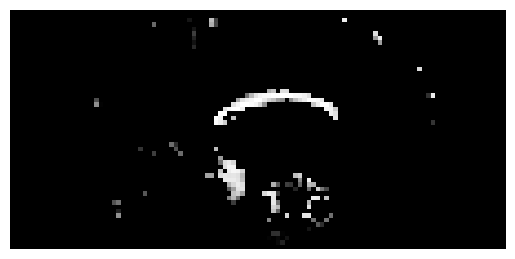

In [133]:
slice_idx = 60
image = bammer1
image = np.where(mask1, image,np.nan)
slice = image[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
# plt.subplot(5,3,i)
plt.axis('off')
cmap = plt.get_cmap('gray')
m = 0
M = 1
im = plt.imshow(slice, vmin=m, vmax=M, cmap=cmap)

In [5]:
def med_scalar(whole_brain):
    m = np.nanmedian(whole_brain)
    return m

In [2]:
def get_data(scalar_file):
    root = '/home/local/VANDERBILT/kanakap/gradtensor/src/noddi'
    mask_root = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/'

    uncorr1 = nib.load(root + '/noddi_output_uncorr1/noddi_' + scalar_file).get_fdata()
    uncorr2 = nib.load(root + '/noddi_output_uncorr2/noddi_' + scalar_file).get_fdata()
    uncorr3 = nib.load(root + '/noddi_output_uncorr3/noddi_' + scalar_file).get_fdata()
    uncorr4 = nib.load(root + '/noddi_output_uncorr4/noddi_' + scalar_file).get_fdata()
    uncorr5 = nib.load(root + '/noddi_output_uncorr5/noddi_' + scalar_file).get_fdata()

    bammer1 = nib.load(root + '/noddi_output_corr1/noddi_' + scalar_file).get_fdata()
    bammer2 = nib.load(root + '/noddi_output_corr2/noddi_' + scalar_file).get_fdata()
    bammer3 = nib.load(root + '/noddi_output_corr3/noddi_' + scalar_file).get_fdata()
    bammer4 = nib.load(root + '/noddi_output_corr4/noddi_' + scalar_file).get_fdata()
    bammer5 = nib.load(root + '/noddi_output_corr5/noddi_' + scalar_file).get_fdata()

    prop1 = nib.load(root + '/noddi_output_proposed1/noddi_' + scalar_file).get_fdata()
    prop2 = nib.load(root + '/noddi_output_proposed2/noddi_' + scalar_file).get_fdata()
    prop3 = nib.load(root + '/noddi_output_proposed3/noddi_' + scalar_file).get_fdata()
    prop4 = nib.load(root + '/noddi_output_proposed4/noddi_' + scalar_file).get_fdata()
    prop5 = nib.load(root + '/noddi_output_proposed5/noddi_' + scalar_file).get_fdata()

    uncorr1[uncorr1 == 0] = 'nan'
    uncorr2[uncorr2 == 0] = 'nan'
    uncorr3[uncorr3 == 0] = 'nan'
    uncorr4[uncorr4 == 0] = 'nan'
    uncorr5[uncorr5 == 0] = 'nan'
    bammer1[bammer1 == 0] = 'nan'
    bammer2[bammer2 == 0] = 'nan'
    bammer3[bammer3 == 0] = 'nan'
    bammer4[bammer4 == 0] = 'nan'
    bammer5[bammer5 == 0] = 'nan'
    prop1[prop1 == 0] = 'nan'
    prop2[prop2 == 0] = 'nan'
    prop3[prop3 == 0] = 'nan'
    prop4[prop4 == 0] = 'nan'
    prop5[prop5 == 0] = 'nan'

    mask1 = nib.load(mask_root + 'sub-cIVs001/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask2 = nib.load(mask_root + 'sub-cIVs002/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask3 = nib.load(mask_root + 'sub-cIVs006/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask4 = nib.load(mask_root + 'sub-cIVs007/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask5 = nib.load(mask_root + 'sub-cIVs005/ses-s1Bx3/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()

    if scalar_file != 'fiso.nii':
        uncorr1 = np.where(mask1 != 1.0, uncorr1,np.nan)
        uncorr2 = np.where(mask2 != 1.0, uncorr2,np.nan)
        uncorr3 = np.where(mask3 != 1.0, uncorr3,np.nan)
        uncorr4 = np.where(mask4 != 1.0, uncorr4,np.nan)
        uncorr5 = np.where(mask5 != 1.0, uncorr5,np.nan)

        uncorr1 = np.where(mask1,uncorr1, np.nan)
        uncorr2 = np.where(mask2,uncorr2, np.nan)
        uncorr3 = np.where(mask3,uncorr3, np.nan)
        uncorr4 = np.where(mask4,uncorr4, np.nan)
        uncorr5 = np.where(mask5,uncorr5, np.nan)

        bammer1 = np.where(mask1 != 1.0, bammer1,np.nan)
        bammer2 = np.where(mask2 != 1.0, bammer2,np.nan)
        bammer3 = np.where(mask3 != 1.0, bammer3,np.nan)
        bammer4 = np.where(mask4 != 1.0, bammer4,np.nan)
        bammer5 = np.where(mask5 != 1.0, bammer5,np.nan)

        bammer1 = np.where(mask1,bammer1, np.nan)
        bammer2 = np.where(mask2,bammer2, np.nan)
        bammer3 = np.where(mask3,bammer3, np.nan)
        bammer4 = np.where(mask4,bammer4, np.nan)
        bammer5 = np.where(mask5,bammer5, np.nan)

        prop1 = np.where(mask1 != 1.0, prop1,np.nan)
        prop2 = np.where(mask2 != 1.0, prop2,np.nan)
        prop3 = np.where(mask3 != 1.0, prop3,np.nan)
        prop4 = np.where(mask4 != 1.0, prop4,np.nan)
        prop5 = np.where(mask5 != 1.0, prop5,np.nan)

        prop1 = np.where(mask1,prop1, np.nan)
        prop2 = np.where(mask2,prop2, np.nan)
        prop3 = np.where(mask3,prop3, np.nan)
        prop4 = np.where(mask4,prop4, np.nan)
        prop5 = np.where(mask5,prop5, np.nan)
    else:
        uncorr1 = np.where(mask1 == 1.0, uncorr1,np.nan)
        uncorr2 = np.where(mask2 == 1.0, uncorr2,np.nan)
        uncorr3 = np.where(mask3 == 1.0, uncorr3,np.nan)
        uncorr4 = np.where(mask4 == 1.0, uncorr4,np.nan)
        uncorr5 = np.where(mask5 == 1.0, uncorr5,np.nan)

        uncorr1 = np.where(mask1,uncorr1, np.nan)
        uncorr2 = np.where(mask2,uncorr2, np.nan)
        uncorr3 = np.where(mask3,uncorr3, np.nan)
        uncorr4 = np.where(mask4,uncorr4, np.nan)
        uncorr5 = np.where(mask5,uncorr5, np.nan)

        bammer1 = np.where(mask1 == 1.0, bammer1,np.nan) # csf
        bammer2 = np.where(mask2 == 1.0, bammer2,np.nan)
        bammer3 = np.where(mask3 == 1.0, bammer3,np.nan)
        bammer4 = np.where(mask4 == 1.0, bammer4,np.nan)
        bammer5 = np.where(mask5 == 1.0, bammer5,np.nan)

        bammer1 = np.where(mask1,bammer1, np.nan)
        bammer2 = np.where(mask2,bammer2, np.nan)
        bammer3 = np.where(mask3,bammer3, np.nan)
        bammer4 = np.where(mask4,bammer4, np.nan)
        bammer5 = np.where(mask5,bammer5, np.nan)

        prop1 = np.where(mask1 == 1.0, prop1,np.nan)
        prop2 = np.where(mask2 == 1.0, prop2,np.nan)
        prop3 = np.where(mask3 == 1.0, prop3,np.nan)
        prop4 = np.where(mask4 == 1.0, prop4,np.nan)
        prop5 = np.where(mask5 == 1.0, prop5,np.nan)

        prop1 = np.where(mask1,prop1, np.nan)
        prop2 = np.where(mask2,prop2, np.nan)
        prop3 = np.where(mask3,prop3, np.nan)
        prop4 = np.where(mask4,prop4, np.nan)
        prop5 = np.where(mask5,prop5, np.nan)

    return uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5

In [8]:
def df_med(uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5):
    k = med_scalar(uncorr1)
    l = med_scalar(uncorr2)
    m = med_scalar(uncorr3)
    n = med_scalar(uncorr4)
    o = med_scalar(uncorr5)

    a = med_scalar(bammer1)
    b = med_scalar(bammer2)
    c = med_scalar(bammer3)
    d = med_scalar(bammer4)
    e = med_scalar(bammer5)

    f = med_scalar(prop1)
    g = med_scalar(prop2)
    h = med_scalar(prop3)
    i = med_scalar(prop4)
    j = med_scalar(prop5)

    uncorr = [k, l, m, n, o]
    bamm = [a, b, c, d, e]
    prop = [f, g, h, i, j]
    dfu = pd.DataFrame(uncorr)
    dfu = dfu.assign(x = 'Uncorrected')

    df = pd.DataFrame(bamm)
    df = df.assign(x = 'Empirical Bammer')
    
    dfp = pd.DataFrame(prop)
    dfp = dfp.assign(x = 'Proposed')

    cat = pd.concat([dfu,df,dfp])
    return cat, uncorr, bamm, prop

In [12]:
def plot_sub(axes, cat, uncorr, bamm, prop, n, title):#, ymin, ymax):

    palette= {'Uncorrected': 'black','Empirical Bammer': 'teal','Proposed': 'rebeccapurple'}
    sns.swarmplot( ax = axes[n], x="x", y=0, hue="x", data=cat, palette=palette)
    # idx0 = 0
    # idx1 = 1
    # locs1 = axes[n].get_children()[idx0].get_offsets()
    # locs2 = axes[n].get_children()[idx1].get_offsets()
    # sort_idxs1 = np.array([0, 1, 2, 3, 4])
    # sort_idxs2 = np.array([0, 1, 2, 3, 4])#np.argsort(prop)
    # locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    # for i in range(locs1.shape[0]):
    #     x = [locs1[i, 0], locs2_sorted[i, 0]]
    #     y = [locs1[i, 1], locs2_sorted[i, 1]]
    #     axes[n].plot(x, y, '--', color="black", alpha=0.2)

    idx0 = 0
    idx1 = 1
    idx2 = 2
    locs1 = axes[n].get_children()[idx0].get_offsets()
    locs2 = axes[n].get_children()[idx1].get_offsets()
    locs3 = axes[n].get_children()[idx2].get_offsets()
    sort_idxs1 = np.array([0, 1, 2, 3, 4])
    sort_idxs2 = np.array([0, 1, 2, 3, 4])
    sort_idxs3 = np.array([0, 1, 2, 3, 4])
    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    locs3_sorted = locs3[sort_idxs3.argsort()][sort_idxs2]
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2_sorted[i, 0]]
        y = [locs1[i, 1], locs2_sorted[i, 1]]
        axes[n].plot(x, y,'--', color="mediumturquoise", alpha=0.3)

    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs3_sorted[i, 0]]
        z = [locs1[i, 1], locs3_sorted[i, 1]]
        axes[n].plot(x, z, '--', color="mediumpurple", alpha=0.3)

    palette= {'Uncorrected': 'darkgrey','Empirical Bammer': 'mediumturquoise','Proposed': 'mediumpurple'}

    bb = sns.boxplot( ax = axes[n], x="x", y=0, hue="x", data=cat,palette=palette, width = 0.4,dodge=False)

    # for i,artist in enumerate(bb.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
      #  col = artist.get_facecolor()
      #  artist.set_edgecolor(col)
      #  artist.set_facecolor('None')
      #  for j in range(i*6,i*6+6):
      #      line = bb.lines[j]
      #      line.set_color(col)
      #      line.set_mfc(col)
      #      line.set_mec(col)

    # axes[n].set(ylim=(ymin, ymax))
    axes[n].set_title(' ', fontsize=15)
    axes[n].set_ylabel('Median ' + title,fontsize = 15)
    axes[n].set_xlabel('')
    axes[n].set_xticklabels([])
    axes[n].tick_params(labelsize=15)
    axes[n].grid(True,linewidth=0.5)
    axes[n].legend([],[],frameon=False)

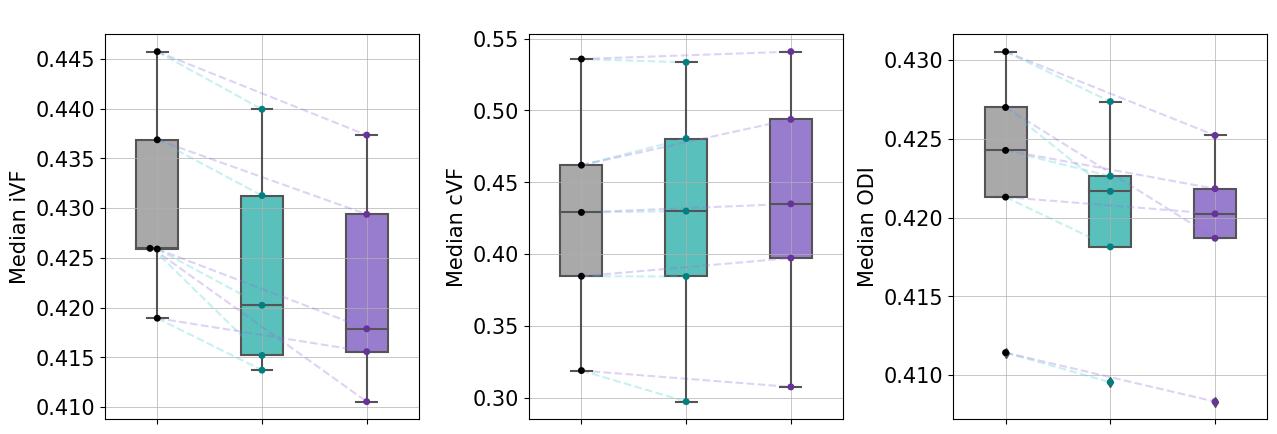

In [13]:
uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5 = get_data('ficvf.nii')
cat_iVF, uncorr_iVF, bamm_iVF, prop_iVF = df_med(uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5)
uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5 = get_data('fiso.nii')
cat_cVF, uncorr_cVF, bamm_cVF, prop_cVF  = df_med(uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5)
uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5 = get_data('odi.nii')
cat_ODI, uncorr_ODI, bamm_ODI, prop_ODI  = df_med(uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5)

fig, axes = plt.subplots(1,3, figsize=(15,5))
plt.rcParams.update({'font.size':15})
plot_sub(axes, cat_iVF, uncorr_iVF, bamm_iVF, prop_iVF, 0, 'iVF')#,  0.078, 0.108)
plot_sub(axes, cat_cVF, uncorr_cVF, bamm_cVF, prop_cVF, 1, 'cVF')#, 0.012, 0.025)
plot_sub(axes, cat_ODI, uncorr_ODI, bamm_ODI, prop_ODI, 2, 'ODI')#, 0.073, 0.098)

axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.subplots_adjust(wspace=0.35,hspace=0.1) 
plt.show()

In [14]:
cat_iVF

,0,x
0,0.425900,Uncorrected
1,0.436879,Uncorrected
2,0.425968,Uncorrected
3,0.418947,Uncorrected
4,0.445741,Uncorrected
0,0.420249,Empirical Bammer
1,0.431276,Empirical Bammer
2,0.415200,Empirical Bammer
3,0.413724,Empirical Bammer
4,0.439947,Empirical Bammer


In [23]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
pivf = stats.wilcoxon(bamm_iVF, uncorr_iVF)
pcvf = stats.wilcoxon(bamm_cVF, uncorr_cVF)
podi = stats.wilcoxon(bamm_ODI, uncorr_ODI)
print(pivf,pcvf,podi)
praw = [pivf.pvalue,pcvf.pvalue,podi.pvalue]
p_adjusted = multipletests(praw, alpha=0.008,method='bonferroni')
print(p_adjusted[1])


WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355) WilcoxonResult(statistic=6.0, pvalue=0.6858304344516057) WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
[0.12934334 1.         0.12934334]


In [24]:
pivf = stats.wilcoxon(bamm_iVF, prop_iVF)
pcvf = stats.wilcoxon(bamm_cVF, prop_cVF)
podi = stats.wilcoxon(bamm_ODI, prop_ODI)
print(pivf,pcvf,podi)
praw = [pivf.pvalue,pcvf.pvalue,podi.pvalue]
p_adjusted = multipletests(praw, alpha=0.008,method='bonferroni')
print(p_adjusted[1])

WilcoxonResult(statistic=1.0, pvalue=0.07961580146011343) WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355) WilcoxonResult(statistic=3.0, pvalue=0.22491588401596185)
[0.2388474  0.12934334 0.67474765]


In [25]:
pivf = stats.wilcoxon(uncorr_iVF, prop_iVF)
pcvf = stats.wilcoxon(uncorr_cVF, prop_cVF)
podi = stats.wilcoxon(uncorr_ODI, prop_ODI)
print(pivf,pcvf,podi)
praw = [pivf.pvalue,pcvf.pvalue,podi.pvalue]
p_adjusted = multipletests(praw, alpha=0.008,method='bonferroni')
print(p_adjusted[1])

WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355) WilcoxonResult(statistic=3.0, pvalue=0.22491588401596185) WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
[0.12934334 0.67474765 0.12934334]


In [115]:
print(p_adjusted[1])

[0.2388474  0.12934334 0.67474765]


In [27]:
def cohend(c0,c1):
    cohens_d = (np.nanmean(c0) - np.nanmean(c1)) / (np.sqrt((np.nanstd(c0) ** 2 + np.nanstd(c1) ** 2) / 2))
    return cohens_d

In [ ]:
def get_data(scalar_file):
    root = '/home/local/VANDERBILT/kanakap/gradtensor/src/noddi'
    mask_root = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/'
    bammer1 = nib.load(root + '/noddi_output_corr1/noddi_' + scalar_file).get_fdata()
    bammer2 = nib.load(root + '/noddi_output_corr2/noddi_' + scalar_file).get_fdata()
    bammer3 = nib.load(root + '/noddi_output_corr3/noddi_' + scalar_file).get_fdata()
    bammer4 = nib.load(root + '/noddi_output_corr4/noddi_' + scalar_file).get_fdata()
    bammer5 = nib.load(root + '/noddi_output_corr5/noddi_' + scalar_file).get_fdata()

    prop1 = nib.load(root + '/noddi_output_proposed1/noddi_' + scalar_file).get_fdata()
    prop2 = nib.load(root + '/noddi_output_proposed2/noddi_' + scalar_file).get_fdata()
    prop3 = nib.load(root + '/noddi_output_proposed3/noddi_' + scalar_file).get_fdata()
    prop4 = nib.load(root + '/noddi_output_proposed4/noddi_' + scalar_file).get_fdata()
    prop5 = nib.load(root + '/noddi_output_proposed5/noddi_' + scalar_file).get_fdata()

    bammer1[bammer1 == 0] = 'nan'
    bammer2[bammer2 == 0] = 'nan'
    bammer3[bammer3 == 0] = 'nan'
    bammer4[bammer4 == 0] = 'nan'
    bammer5[bammer5 == 0] = 'nan'
    prop1[prop1 == 0] = 'nan'
    prop2[prop2 == 0] = 'nan'
    prop3[prop3 == 0] = 'nan'
    prop4[prop4 == 0] = 'nan'
    prop5[prop5 == 0] = 'nan'
    
    mask1 = nib.load(mask_root + 'sub-cIVs001/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask2 = nib.load(mask_root + 'sub-cIVs002/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask3 = nib.load(mask_root + 'sub-cIVs006/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask4 = nib.load(mask_root + 'sub-cIVs007/ses-s1Bx2/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()
    mask5 = nib.load(mask_root + 'sub-cIVs005/ses-s1Bx3/fast_reg1/LABELS_IN_DWI.nii.gz').get_fdata()

    if scalar_file != 'fiso.nii':
        bammer1 = np.where(mask1 != 1.0,bammer1, np.nan) # wm gm 
        bammer1 = np.where(mask1 != 1.0, bammer1,np.nan)
        bammer2 = np.where(mask2 != 1.0, bammer2,np.nan)
        bammer3 = np.where(mask3 != 1.0, bammer3,np.nan)
        bammer4 = np.where(mask4 != 1.0, bammer4,np.nan)
        bammer5 = np.where(mask5 != 1.0, bammer5,np.nan)

        prop1 = np.where(mask1 != 1.0, prop1,np.nan)
        prop2 = np.where(mask2 != 1.0, prop2,np.nan)
        prop3 = np.where(mask3 != 1.0, prop3,np.nan)
        prop4 = np.where(mask4 != 1.0, prop4,np.nan)
        prop5 = np.where(mask5 != 1.0, prop5,np.nan)
    else:
        bammer1 = np.where(mask1 == 1.0, bammer1,np.nan) # csf
        bammer2 = np.where(mask2 == 1.0, bammer2,np.nan)
        bammer3 = np.where(mask3 == 1.0, bammer3,np.nan)
        bammer4 = np.where(mask4 == 1.0, bammer4,np.nan)
        bammer5 = np.where(mask5 == 1.0, bammer5,np.nan)

        prop1 = np.where(mask1 == 1.0, prop1,np.nan)
        prop2 = np.where(mask2 == 1.0, prop2,np.nan)
        prop3 = np.where(mask3 == 1.0, prop3,np.nan)
        prop4 = np.where(mask4 == 1.0, prop4,np.nan)
        prop5 = np.where(mask5 == 1.0, prop5,np.nan)
    
    return bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5

In [29]:
uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5 = get_data('ficvf.nii')
c1 = cohend(bammer1, uncorr1)
c2 = cohend(bammer2, uncorr2)
c3 = cohend(bammer3, uncorr3)
c4 = cohend(bammer4, uncorr4)
c5 = cohend(bammer5, uncorr5)
print(c1, c2, c3, c4, c5)

-0.02631555327784562 -0.02585554739592874 -0.06197984122070155 -0.024389362927231196 -0.022559138754946195


In [ ]:
# ficvf.nii
bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data('ficvf.nii')
bammer1 = np.where(mask1, bammer1,np.nan)
bammer2 = np.where(mask2, bammer2,np.nan)
bammer3 = np.where(mask3, bammer3,np.nan)
bammer4 = np.where(mask4, bammer4,np.nan)
bammer5 = np.where(mask5, bammer5,np.nan)

prop1 = np.where(mask1, prop1,np.nan)
prop2 = np.where(mask2, prop2,np.nan)
prop3 = np.where(mask3, prop3,np.nan)
prop4 = np.where(mask4, prop4,np.nan)
prop5 = np.where(mask5, prop5,np.nan)
c1 = cohend(bammer1, prop1)
c2 = cohend(bammer2, prop2)
c3 = cohend(bammer3, prop3)
c4 = cohend(bammer4, prop4)
c5 = cohend(bammer5, prop5)
print(c1, c2, c3, c4, c5)

In [28]:
# fiso.nii
uncorr1,uncorr2,uncorr3,uncorr4,uncorr5,bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5 = get_data('fiso.nii')
bammer1 = np.where(mask1, bammer1,np.nan)
bammer2 = np.where(mask2, bammer2,np.nan)
bammer3 = np.where(mask3, bammer3,np.nan)
bammer4 = np.where(mask4, bammer4,np.nan)
bammer5 = np.where(mask5, bammer5,np.nan)

prop1 = np.where(mask1, prop1,np.nan)
prop2 = np.where(mask2, prop2,np.nan)
prop3 = np.where(mask3, prop3,np.nan)
prop4 = np.where(mask4, prop4,np.nan)
prop5 = np.where(mask5, prop5,np.nan)

c1 = cohend(bammer1, prop1)
c2 = cohend(bammer2, prop2)
c3 = cohend(bammer3, prop3)
c4 = cohend(bammer4, prop4)
c5 = cohend(bammer5, prop5)
print(c1, c2, c3, c4, c5)

-0.010840592162186179 -0.009547074713573456 -0.01833637039005087 -0.009338672347411137 -0.004973541206085872


In [ ]:
# odi.nii
bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data('odi.nii')
bammer1 = np.where(mask1, bammer1,np.nan)
bammer2 = np.where(mask2, bammer2,np.nan)
bammer3 = np.where(mask3, bammer3,np.nan)
bammer4 = np.where(mask4, bammer4,np.nan)
bammer5 = np.where(mask5, bammer5,np.nan)

prop1 = np.where(mask1, prop1,np.nan)
prop2 = np.where(mask2, prop2,np.nan)
prop3 = np.where(mask3, prop3,np.nan)
prop4 = np.where(mask4, prop4,np.nan)
prop5 = np.where(mask5, prop5,np.nan)

c1 = cohend(bammer1, prop1)
c2 = cohend(bammer2, prop2)
c3 = cohend(bammer3, prop3)
c4 = cohend(bammer4, prop4)
c5 = cohend(bammer5, prop5)
print(c1, c2, c3, c4, c5)

In [1]:
import numpy as np
from numpy import linspace
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import nibabel as nib

In [ ]:
def plot_den(axes, bammer, prop, x, y):
    # plot histogram chart for var1
    prop = prop.flatten()
    bammer = bammer.flatten()
    bammer = bammer[~np.isnan(bammer)]
    prop = prop[~np.isnan(prop)]
    #sns.histplot(x=prop, bins=20, edgecolor='black', ax=axes[x,y])
    sns.histplot(x=prop, stat="density", bins=20, edgecolor='black', ax=axes[x,y])
    

    # plot histogram chart for var2
    n_bins = 20
    # get positions and heights of bars
    heights, bins = np.histogram(bammer, density=True, bins=n_bins) 
    # heights, bins = np.histogram(bammer, density=True, bins=n_bins) 

    # multiply by -1 to reverse it
    heights *= -1
    bin_width = np.diff(bins)[0]
    bin_pos =( bins[:-1] + bin_width / 2) * 1

    # plot
    axes[x,y].bar(bin_pos, heights, width=bin_width, edgecolor='black')


In [ ]:
fig, axes = plt.subplots(5,3, figsize=(12,18))
plt.rcParams.update({'font.size':15})
s = ['ficvf.nii', 'fiso.nii', 'odi.nii']
for i in range(3):
    bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data(s[i])
    
    plot_den(axes, bammer1, prop1,  0, i)
    plot_den(axes, bammer2, prop2,  1, i)
    plot_den(axes, bammer3, prop3,  2, i)
    plot_den(axes, bammer4, prop4,  3, i)
    plot_den(axes, bammer5, prop5,  4, i)

plt.subplots_adjust(wspace=0.5,hspace=0.15) 


In [ ]:
def plot_slice(image,i, mask):
    slice_idx = 60
    image = np.where(mask, image,0)
    slice = image[slice_idx, :,:]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    plt.subplot(3,5,i)
    plt.axis('off')
    cmap = plt.get_cmap('gray')
    m = 0
    M = 1
    im = plt.imshow(slice, vmin=m, vmax=M, cmap=cmap)
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="3%", pad=0.10)
    a = plt.colorbar(im, cax=cax)

In [ ]:
# for colorbar
fig = plt.figure(figsize=(15,10))
for i in range(1):
    plot_slice(d[i], i+1, m[i])

In [ ]:
fig, axes = plt.subplots(3,5, figsize=(16,5))
plt.rcParams.update({'font.size':15})
bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data('ficvf.nii')

# d = [bammer1,prop1, np.abs(bammer1 - prop1), 
#     bammer2,prop2, np.abs(bammer2 - prop2), 
#     bammer3,prop3, np.abs(bammer3 - prop3),
#     bammer4,prop4, np.abs(bammer4 - prop4),
#     bammer5,prop5, np.abs(bammer5 - prop5)]

# m = [mask1, mask1, mask1,
#     mask2, mask2, mask2,
#     mask3, mask3, mask3,
#     mask4, mask4, mask4,
#     mask5, mask5, mask5]

d = [bammer1,bammer2,bammer3,bammer4,bammer5,
    prop1,prop2,prop3,prop4,prop5,
    np.abs(bammer1 - prop1), np.abs(bammer2 - prop2), np.abs(bammer3 - prop3), np.abs(bammer4 - prop4),  np.abs(bammer5 - prop5)]

m = [mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5]
    
for i in range(15):
    plot_slice(d[i], i+1, m[i])

plt.subplots_adjust(wspace=0.01,hspace=0.001) 

In [ ]:
fig, axes = plt.subplots(3,5, figsize=(16,5))
plt.rcParams.update({'font.size':15})
bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data('fiso.nii')

d = [bammer1,bammer2,bammer3,bammer4,bammer5,
    prop1,prop2,prop3,prop4,prop5,
    np.abs(bammer1 - prop1), np.abs(bammer2 - prop2), np.abs(bammer3 - prop3), np.abs(bammer4 - prop4),  np.abs(bammer5 - prop5)]

m = [mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5]

    
for i in range(15):
    plot_slice(d[i], i+1, m[i])

plt.subplots_adjust(wspace=0.01,hspace=0.001) 

In [ ]:
fig, axes = plt.subplots(3,5, figsize=(16,5))
plt.rcParams.update({'font.size':15})
bammer1,bammer2,bammer3,bammer4,bammer5,prop1,prop2,prop3,prop4,prop5,mask1,mask2,mask3,mask4,mask5 = get_data('odi.nii')

d = [bammer1,bammer2,bammer3,bammer4,bammer5,
    prop1,prop2,prop3,prop4,prop5,
    np.abs(bammer1 - prop1), np.abs(bammer2 - prop2), np.abs(bammer3 - prop3), np.abs(bammer4 - prop4),  np.abs(bammer5 - prop5)]

m = [mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5,
    mask1,mask2,mask3,mask4,mask5]
    
for i in range(15):
    plot_slice(d[i], i+1, m[i])

plt.subplots_adjust(wspace=0.01,hspace=0.001) 